# Restauración de Imágenes Digitales

In [245]:
import matplotlib. pyplot as plt
import numpy as np
import math
import pandas as pd
import scipy
from scipy.signal import convolve2d

Creamos la función para cuatificar la distancia entre dos imagenes $\Theta$ y $X$ definidas en un plano en común. Tomamos la definición de la distancia de Hamming:

\begin{equation}
F(\Theta,X) = \sum_{i\in S} I(\theta_i \neq x_i)
\end{equation}

Donde $I(\eta) = 1$ si $\eta$ es verdad y  $I(\eta) = 0$ si $\eta$ es falso

In [2]:
def HammDis(Th,X):
    return np.sum(np.ones_like((Th-X)[(Th-X) != 0]))

In [662]:
def Energy_Ising(Th):
    N = len(Th)
    dTh = []
    for i in range(len(Th)):
        for j in range(len(Th)):
            #dTh = []
            dTh.append(Th[i,j]-Th[(i+1)%N,j])
            dTh.append(Th[i,j]-Th[i,(j+1)%N])
            dTh.append(Th[i,j]-Th[(i-1)%N,j])
            dTh.append(Th[i,j]-Th[i,(j-1)%N])
    Eij = np.array(dTh).T
    return -len(Eij[Eij == 0])

El Prior debe reflejar que debería ser la imagen limpia. Además, esperamos que una imagen sea suave. Decimos que un píxel está conectado sin problemas a su vecino si los niveles de gris en ellos son los mismos. Entre menor es la diferencia entre los niveles de gris de los pixeles cercanos, más suave es la conexión.

Introduciendo una energía de interacción entre los estados de dos píxeles (nivel de gris) y confinamos la interacción a los píxeles vecinos más cercanos. Así, los estados de un par $i, j$ de píxeles vecinos más cercanos interactúan con una energía denotada por $E_{i,j}$. Tomamos las interacciones como aditivo por pares y definimos una energía de la imagen $\Theta$ como:

\begin{equation}
E(\Theta) = \sum_{<i,j>} E_{i,j}(\Theta)
\end{equation}

En lo anterior, el símbolo $<i, j>$ denota que los píxeles $i$ y $j$ son vecinos más cercanos y la suma se toma sobre todos los pares distintos de píxeles vecinos más cercanos en el plano de la imagen. Modelamos $E_{i, j}$ de tal manera que es pequeño cuando los niveles de gris están cerca uno del otro y grande cuando los niveles de gris difieren en gran medida.

Gemen y McClure [17] recomendaron un Prior en el que los estados de dos píxeles vecinos interactúan con una energía dada por:

\begin{equation}
 E_{i,j}(\Theta) = -\frac{1}{1 + C(\theta_i - \theta_j)^2}
\end{equation}

donde C determina el ancho de la distribución. Adelante se crea la función para calcular la energía $E_{i,j}$ entre dos pixeles sercanos: 

In [320]:
def Energy(Th,C):
    N = len(Th)
    Eij = []
    for i in range(len(Th)):
        for j in range(len(Th)):
            dTh = []
            dTh.append(Th[i,j]-Th[(i+1)%N,j])
            dTh.append(Th[i,j]-Th[i,(j+1)%N])
            dTh.append(Th[i,j]-Th[(i-1)%N,j])
            dTh.append(Th[i,j]-Th[i,(j-1)%N])
            Eij.append(-1/(1+(C*np.array(dTh)**2)))
    return np.sum(np.sum(Eij,axis=1))

Mostramos la energía $E_{i,j}$ de Gemen-McClure para diferentes parametrso C:

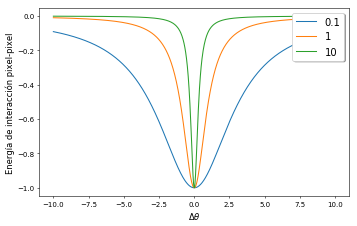

In [4]:
plt.figure(figsize=(8,5), dpi=50)
dTh = np.linspace(-10,10,1000)
for C in [0.1,1,10]:
    plt.plot(dTh,-1/(1+(C*(dTh)**2)),label = C)
plt.xlabel('$\Delta \\theta$', fontsize=12)
plt.ylabel('Energía de interacción pixel-pixel', fontsize=12)
plt.legend(loc='upper right', shadow=True, fontsize='x-large')

In [5]:
#p = 1 - (1/Q)
#betaL = np.ln((1/p) - 1)

## Distribución bayesiana a posteriori:

Usando el teorema de Bayes:

\begin{equation}
p(\Theta|X) = \frac{\mathscr{L}(X|\theta)p(\theta)}{\sum_{\Theta}\mathscr{L}(X|\theta)p(\theta) }
\end{equation}

La expresión final para el Posteriori que utilizaremos en este algoritmo de restauración de imagen viene dada por:

\begin{equation}
p(\Theta|X) = \frac{\exp\left[ -\frac{1}{L^2(1+\beta)}\left( F(\Theta,X) + \frac{1}{2}\beta E(\Theta) \right) \right]}{\sum_{\Theta} \exp\left[ -\frac{1}{L^2(1+\beta)}\left( F(\Theta,X) + \frac{1}{2}\beta E(\Theta) \right) \right]}
\end{equation}

In [6]:
def posteriori(Th,X,L,beta,C):
    a = 1/((1+beta)*L**2)
    return np.exp(-a*(HammDis(Th,X) + ((beta/2)*(Energy(Th,C)))))

In [659]:
def posteriori_Ising(Th,X,L,beta):
    a = 1/((1+beta)*L**2)
    return np.exp(-a*(HammDis(Th,X) + ((beta/2)*(Energy_Ising(Th)))))

## Imagen Binaria

Generamos una imagen Binaria con ruido

In [7]:
from PIL import Image
from resizeimage import resizeimage

Importamos la imagen de un robot y resudimos su tamaño con "resizeimage"

In [700]:
robot = Image.open("robot_1.png")
ratio = float((robot.size[1]) / (robot.size[0]))
robot = resizeimage.resize_cover(robot, [35, int(ratio * 35)])
robot = np.asarray(robot).copy()
robot.setflags(write=1)
robot[(robot!=0)&(robot!=255)] = 255
robot = robot / 255

Mostramos la imagen del robot original y limpia:

Text(0,0.5,'j')

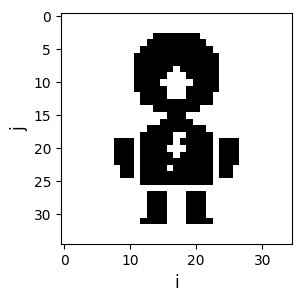

In [701]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(robot, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)

Generamos la imagen con ruido de 5%

In [702]:
L = len(robot)
imgnoise = robot.copy()
ruido = 0.03

for i in range(len(imgnoise)):
    for j in range(len(imgnoise[0])):
        eps = np.random.uniform(0,1)
        if eps <= ruido:
            if imgnoise[i,j] == 0:
                imgnoise[i,j] = 1
            else:
                imgnoise[i,j] = 0
        else:
            continue

Text(0,0.5,'j')

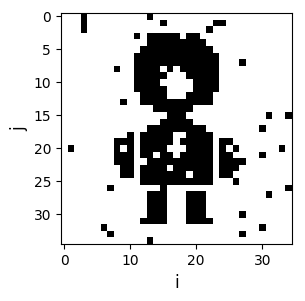

In [703]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(imgnoise, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)

In [706]:
Th = imgnoise.copy()
Th_prob = imgnoise.copy()
L = len(imgnoise)
p = ruido
e = (1/p) - 1
T = 0.51
betaP = (1/T)/(np.log1p(e))

for i in range(2*5000):
    
    pi_c = posteriori_Ising(Th,imgnoise,L,betaP)
    
    n = np.random.randint(L)
    m = np.random.randint(L)
    if Th[n,m] == 0:
        Th_prob[n,m] = 1
    else:
        Th_prob[n,m] = 0
    
    pi_t = posteriori_Ising(Th_prob,imgnoise,L,betaP)
    if (pi_t/pi_c)>1:
        Th = Th_prob.copy()
    else:
        Th_prob = Th.copy()
        

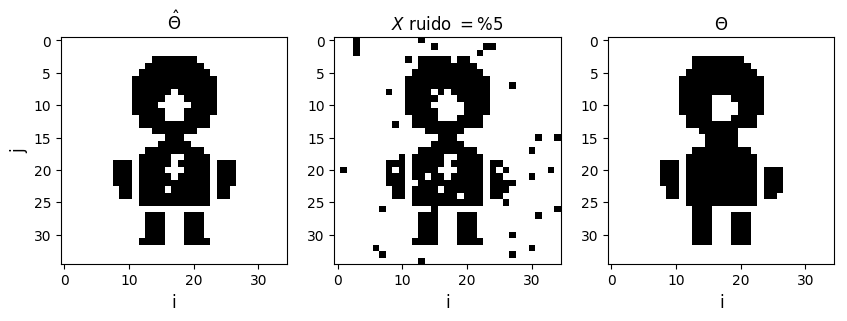

In [707]:
plt.style.use('default')
plt.figure(figsize=(10,10), dpi=100)
plt.subplot(331)
plt.imshow(robot, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$\hat{\Theta}$')

plt.subplot(332)
plt.imshow(imgnoise, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.title('$X$ ruido $= \%5$')

plt.subplot(333)
plt.imshow(Th, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.title('$\Theta$')
plt.savefig('Robor_1.jpg')

In [678]:
robot_2 = np.loadtxt('robot_1.csv',delimiter=',')

Text(0,0.5,'j')

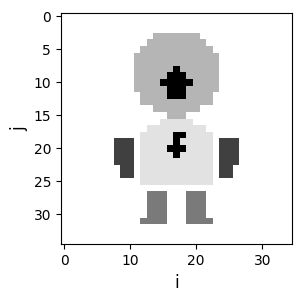

In [708]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(robot_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)

In [711]:
L = len(robot_2)
imgnoise_2 = robot_2.copy()
ruido = 0.05
Q = np.max(robot_2)

for i in range(len(imgnoise_2)):
    for j in range(len(imgnoise_2[0])):
        eps = np.random.uniform(0,1)
        if eps <= ruido:
            imgnoise_2[i,j] = np.random.randint(Q)
        else:
            continue

Text(0,0.5,'j')

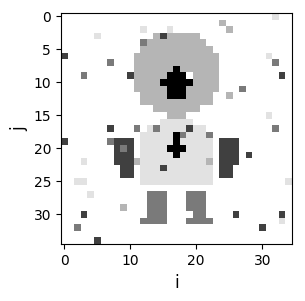

In [712]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(imgnoise_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)

In [715]:
Th_2 = imgnoise_2.copy()
Th_prob_2 = imgnoise_2.copy()
Q = np.array([0,1,2,3,4,5])
L = len(imgnoise_2)
T = 0.51
p = 0.05
e = (5-1)*((1/p)-1)
beta = (1/T)/(np.log1p(e))


for i in range(2*5000):
    pi_c = posteriori(Th_2,imgnoise_2,L,beta,1)
    n = np.random.randint(L)
    m = np.random.randint(L)
    Th_prob_2[n,m] = np.random.choice(Q[Q != Th_prob_2[n,m]]) #Escojemos otro nivel de Gris diferente al del pixel escojido
    pi_t = posteriori(Th_prob_2,imgnoise_2,L,beta,1)
    if (pi_t/pi_c)>1:
        Th_2 = Th_prob_2.copy()
    else:
        Th_prob_2 = Th_2.copy()
        

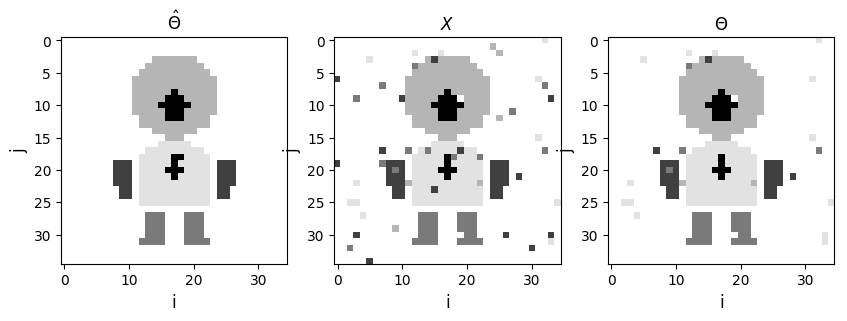

In [716]:
plt.figure(figsize=(10,10), dpi=100)
plt.subplot(331)
plt.imshow(robot_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$\hat{\Theta}$')

plt.subplot(332)
plt.imshow(imgnoise_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$X$')

plt.subplot(333)
plt.imshow(Th_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$\Theta$')
plt.savefig('Robor_2.jpg')

In [698]:
Th_3 = imgnoise_2.copy()
Th_prob_3 = imgnoise_2.copy()
Q = np.array([0,1,2,3,4,5])
L = len(imgnoise_2)
T = 0.051
p = 0.05
e = (5-1)*((1/p)-1)
beta = (1/T)/(np.log1p(e))


for i in range(500):
    pi_c = posteriori(Th_3,imgnoise_2,L,beta,1)
    n = np.random.randint(L)
    m = np.random.randint(L)
    Th_prob_3[n,m] = np.random.choice(Q[Q != Th_prob_3[n,m]]) #Escojemos otro nivel de Gris al del pixel escojido
    pi_t = posteriori(Th_prob_3,imgnoise_2,L,beta,1)
    P_hat = pi_t/(pi_t+pi_c) 
    
    eps = np.random.uniform(0,1)
    
    if eps <= P_hat:
        #print('P= ',P_hat)
        #print('eps= ',eps)
        Th_3 = Th_prob_3.copy()
    else:
        Th_prob_3 = Th_3.copy()

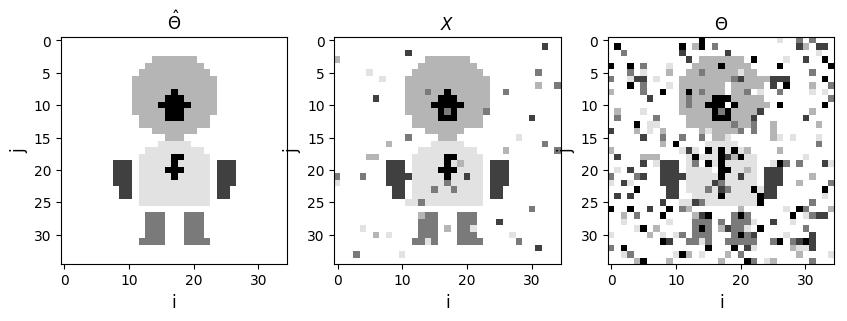

In [699]:
plt.figure(figsize=(10,10), dpi=100)
plt.subplot(331)
plt.imshow(robot_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$\hat{\Theta}$')

plt.subplot(332)
plt.imshow(imgnoise_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$X$')

plt.subplot(333)
plt.imshow(Th_3, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$\Theta$')
plt.savefig('Robor_3.jpg')